In [1]:
import sys
import json

footpaths = {'max_length': '1000', 'speed': '2.8', 'n_ntlegs': '2'}
params = {'footpaths': footpaths}

default = {'training_folder': '../../scenarios/montreal', 'params': params, 'period': ''}
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)

{'training_folder': '../../scenarios/montreal', 'params': {'footpaths': {'max_length': '1000', 'speed': '2.8', 'n_ntlegs': '2'}}, 'period': ''}


In [2]:
import os
import geopandas as gpd
import pandas as pd

sys.path.insert(0, r'../../../quetzal')  # Add path to quetzal
from shapely.geometry import Point, LineString
from quetzal.model import stepmodel
from quetzal.io.quenedi import read_parameters, restrict_df_to_variant


on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))

In [3]:
def get_epsg(lat: float, lon: float) -> int:
	"""
	return EPSG in meter for a given (lat,lon)
	lat is north south
	lon is est west
	"""
	return int(32700 - round((45 + lat) / 90, 0) * 100 + round((183 + lon) / 6, 0))

# Folders stucture and params

everything is on S3 (nothing on ECR) so no direct input folder. just scenarios/{scen}/inputs/

In [4]:
period = argv.get('period', '')

In [5]:
base_folder = argv['training_folder']
input_folder = os.path.join(base_folder, 'inputs')
pt_folder = os.path.join(input_folder, 'pt')
road_folder = os.path.join(input_folder, 'road')
od_folder = os.path.join(input_folder, 'od')

output_folder = os.path.join(base_folder, 'outputs', period)
if not os.path.exists(output_folder):
	os.makedirs(output_folder)

print('input folder: ', input_folder)
print('input folder: ', pt_folder)
print('output folder: ', output_folder)


input folder:  ../../scenarios/montreal/inputs
input folder:  ../../scenarios/montreal/inputs/pt
output folder:  ../../scenarios/montreal/outputs/


In [6]:
params = read_parameters(argv['params'], period=period)

In [7]:
max_length = float(params['footpaths']['max_length'])
speed = float(params['footpaths']['speed'])
n_ntlegs = int(params['footpaths']['n_ntlegs'])


# inputs

In [8]:
links = gpd.read_file(os.path.join(pt_folder, 'links.geojson'))
nodes = gpd.read_file(os.path.join(pt_folder, 'nodes.geojson'))
links = links.set_index('index')
nodes = nodes.set_index('index')

In [9]:
links = restrict_df_to_variant(links, period)
# only keep links with headway not 0
links = links[links['headway'] != 0]

keep and rename:  {}
drops:  []


In [10]:
# rnodes_file = os.path.join(road_folder, 'road_nodes.geojson')
# rnodes_file_provided = os.path.isfile(rnodes_file)
# if rnodes_file_provided:
# 	rnodes = gpd.read_file(os.path.join(road_folder, 'road_nodes.geojson'))
# 	rnodes = rnodes.set_index('index')
# 	rlinks = gpd.read_file(os.path.join(road_folder, 'road_links.geojson'))
# 	rlinks = rlinks.set_index('index')
# print('rnodes?', rnodes_file_provided)

In [11]:
od_file = os.path.join(od_folder, 'od.geojson')
od_file_provided = os.path.isfile(od_file)
if od_file_provided:
	od_test = gpd.read_file(od_file)
	if 'name' not in od_test.columns:
		od_test['name'] = od_test['index']
	od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))
else:
	print('end of pathfinder')
	end_of_notebook

end_of_notebook here if OD_file not provided!!

In [12]:
od_test['geometry_o'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][0]))
od_test['geometry_d'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][1]))

od_test['origin'] = od_test['index'].astype(str) + '_o'
od_test['destination'] = od_test['index'].astype(str) + '_d'


zones = od_test.copy()
zones_d = od_test.copy()
zones['geometry'] = zones['geometry_o']
zones_d['geometry'] = zones_d['geometry_d']
zones['index'] = zones['origin']
zones_d['index'] = zones_d['destination']
zones = pd.concat([zones[['index', 'geometry']], zones_d[['index', 'geometry']]])
zones = zones.set_index('index')

od_set = set(zip(od_test['origin'], od_test['destination']))


# preparation

In [13]:
def add_col(links, col='length'):
	if col not in links.columns:
		return True
	elif any(links[col].isnull()):
		return True
	else:
		return False

In [14]:
if add_col(links, 'length'):
	print('add length')
	centroid = [*LineString(nodes.centroid.values).centroid.coords][0]
	crs = get_epsg(centroid[1], centroid[0])
	print('create length from geometry')
	links['length'] = links.to_crs(crs).length

if add_col(links, 'speed'):
	print('add speed')
	links['speed'] = links['length'] / links['time'] * 3.6


# Walkmodel

In [15]:
sm = stepmodel.StepModel(epsg=4326)
sm.links = links
sm.nodes = nodes
sm.zones = zones

# sm.road_links = rlinks
# sm.road_nodes = rnodes

In [16]:
# We remove highway for the walkmodel
# walk_type = ['Artere','Collectrices','Locale','Nationale','Regionale']
# walkmodel.road_links = walkmodel.road_links[~walkmodel.road_links['highway'].isin(walk_type)]
# walkmodel.road_nodes = walkmodel.road_nodes.loc[list(np.unique(walkmodel.road_links[['a','b']].values.flatten()))]
# walkmodel.preparation_clusterize_nodes(distance_threshold=0.000002)
# Footpath between PT nodes
sm.preparation_footpaths(speed=speed, max_length=max_length, clusters_distance=0.00001)

In [17]:
# Access footpaths (zone_to_road and road_to_transit)
sm.preparation_ntlegs(
	short_leg_speed=speed,
	long_leg_speed=speed,  # tout le monde marche
	threshold=1000,
	zone_to_transit=True,
	zone_to_road=False,
	road_to_transit=False,
	n_ntlegs=n_ntlegs,
	# max_ntleg_length=2000,
)

In [18]:
# Copy connectors to the model
sm.footpaths = sm.footpaths.drop(columns='voronoi')
# sm.footpaths = walkmodel.footpaths.drop(columns='voronoi').copy()
# sm.zone_to_transit = walkmodel.zone_to_transit.copy()

In [19]:
sm.footpaths['speed'] = sm.footpaths['length'] / sm.footpaths['time'] * 3.6


# pathfinder

In [20]:
sm.step_pt_pathfinder(
	broken_routes=False,
	broken_modes=False,
	keep_pathfinder=True,
	mode_column='route_type',
	route_column='route_id',
	speedup=True,
	walk_on_road=False,
	path_analysis=False,
	od_set=od_set,
)


start publicpathfinder
12 sources 12 targets direct search
path_analysis


In [21]:
sm.analysis_pt_los(walk_on_road=False)

path_analysis: 100%|██████████| 12/12 [00:00<00:00, 54120.05it/s]


# create path

In [22]:
od_links = od_test.merge(sm.pt_los[['origin', 'destination', 'gtime', 'link_path']], on=['origin', 'destination'])
od_links = od_links.drop(columns=['geometry', 'geometry_o', 'geometry_d', 'origin', 'destination'])
od_links = od_links.explode('link_path')
# may add route_width if quenedi can handle it one day.
od_links = od_links.merge(sm.links[['route_color', 'geometry', 'time', 'speed']], left_on='link_path', right_index=True)
od_links = od_links.drop(columns='link_path')

In [23]:
od_ntlegs = od_test.merge(sm.pt_los[['origin', 'destination', 'gtime', 'ntlegs']], on=['origin', 'destination'])
od_ntlegs = od_ntlegs.drop(columns=['geometry', 'geometry_o', 'geometry_d', 'origin', 'destination'])
od_ntlegs = od_ntlegs.explode('ntlegs')

ntlegs_dict = sm.zone_to_transit.reset_index().set_index(['a', 'b'])['index'].to_dict()
od_ntlegs['ntlegs'] = od_ntlegs['ntlegs'].apply(ntlegs_dict.get)

od_ntlegs = od_ntlegs.merge(sm.zone_to_transit[['geometry', 'time', 'speed']], left_on='ntlegs', right_index=True)
od_ntlegs = od_ntlegs.drop(columns='ntlegs')
# od_ntlegs['route_color']='4B4B4B'

In [24]:
od_footpaths = od_test.merge(sm.pt_los[['origin', 'destination', 'gtime', 'footpaths']], on=['origin', 'destination'])
od_footpaths = od_footpaths.drop(columns=['geometry', 'geometry_o', 'geometry_d', 'origin', 'destination'])
od_footpaths = od_footpaths.explode('footpaths')

footpaths_dict = sm.footpaths.reset_index().set_index(['a', 'b'])['index'].to_dict()
od_footpaths['footpaths'] = od_footpaths['footpaths'].apply(footpaths_dict.get)

od_footpaths = od_footpaths.merge(sm.footpaths[['geometry', 'time', 'speed']], left_on='footpaths', right_index=True)
od_footpaths = od_footpaths.drop(columns='footpaths')

In [25]:
od_route = pd.concat([od_links, od_footpaths, od_ntlegs], axis=0)

In [26]:
od_route['route_color'] = od_route['route_color'].fillna('838383')
od_route['route_color'] = '#' + od_route['route_color']

In [27]:
od_route = od_route.rename(columns={'name': 'od_name'}).drop(columns='index')
od_route.reset_index(drop=True)
od_route.index.name = 'index'

In [28]:
od_route = gpd.GeoDataFrame(od_route, crs=4326)
od_route.to_file(os.path.join(output_folder, 'od_route.geojson'), driver='GeoJSON')

# export PT lost metrics

In [29]:
sm.analysis_pt_time()
sm.analysis_pt_route_type(['rail', 'subway', 'tram', 'bus', 'ferry', 'cable_car', 'gondola', 'funicular'])
pt_los = od_test[['origin', 'destination', 'name']].merge(sm.pt_los, on=['origin', 'destination'])

In [30]:
pt_los['walking_time'] = pt_los['access_time'] + pt_los['footpath_time']
time_per_mode_cols = []
# get in_vehicle_time per modes
mode_list = sm.links['route_type'].unique()
for mode in mode_list:
	time_dict = sm.links[sm.links['route_type'] == mode]['time'].to_dict()
	col = f'{mode}_time'
	pt_los[col] = pt_los['path'].apply(lambda ls: sum([time_dict.get(el, 0) for el in ls]))
	time_per_mode_cols.append(col)


In [31]:
time_cols = ['walking_time', 'waiting_time', 'boarding_time', *time_per_mode_cols]
cols = ['name', 'time', 'in_vehicle_time', *time_cols, 'ntransfers', 'route_types']
pt_los = pt_los[cols]
pt_los.index.name = 'index'

In [32]:
pt_los.to_csv(os.path.join(output_folder, 'od_los.csv'))

In [33]:
print('pathfinder successfull')

pathfinder successfull


In [34]:
# pt_los

# Bar plot

In [35]:
import matplotlib.pyplot as plt

systra_colors = [
	'#74a9cf',
	'#0570b0',
	'#bdc9e1',
	'#b2df8a',
	'#33a02c',
	'#fb9a99',
	'#e31a1c',
	'#fdbf6f',
	'#ff7f00',
	'#cab2d6',
	'#6a3d9a',
]


In [36]:
to_plot = pt_los.copy()
to_plot = to_plot.set_index('name')
to_plot[time_cols] = to_plot[time_cols] / 60

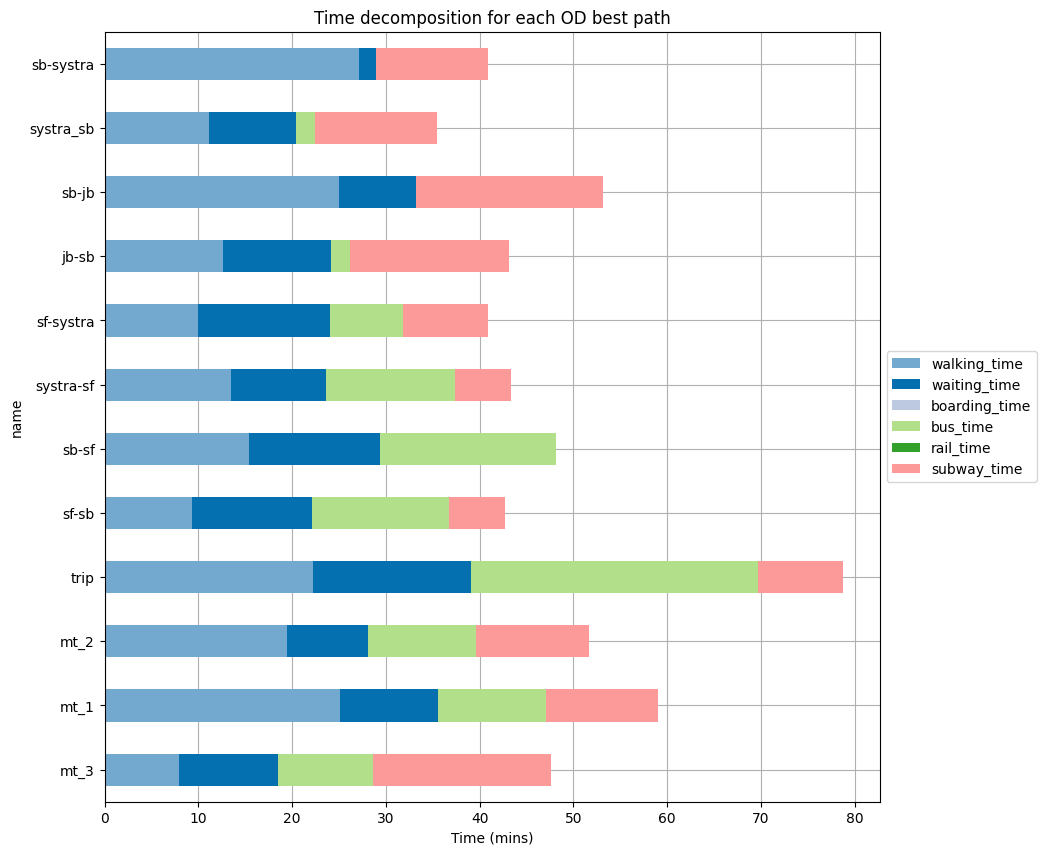

In [37]:
ax = to_plot[time_cols].plot(kind='barh', stacked=True, figsize=(10, 10), color=systra_colors)
plt.legend(loc='upper right', ncol=1)
plt.gca().invert_yaxis()
plt.xlabel('Time (mins)')
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.legend(time_cols, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('Time decomposition for each OD best path')
plt.savefig(os.path.join(output_folder, 'od_time_decomposition.png'))

In [38]:
output_folder

'../../scenarios/montreal/outputs/'

# Isochrone

In [ ]:
from syspy.spatial.spatial import agglomerative_clustering, voronoi_diagram_dataframes, zone_clusters

In [40]:
nodes = sm.nodes
label = agglomerative_clustering(sm.nodes, distance_threshold=2e-3)
nodes['cluster'] = label
nodes = nodes.drop_duplicates('cluster')

In [41]:
from shapely.geometry import multipoint, multilinestring
import numpy as np


def coords(g):
	l = list(g.coords)
	a, b = l[0], l[-1]
	xa, ya = a
	xb, yb = b
	return [xa, xb, ya, yb]

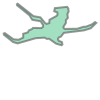

In [ ]:
from shapely import geometry
from shapely.ops import unary_union as u2

m = sm.copy()
tolerance = 1e-2
n = 5
m.preparation_clusterize_nodes(distance_threshold=n * tolerance)
links = m.links.loc[m.links['a'] != m.links['b']]
df = pd.DataFrame(
	data=list(links['geometry'].apply(coords).values), index=links.index, columns=['xa', 'xb', 'ya', 'yb']
)
df['length'] = np.sqrt(np.power(df['yb'] - df['ya'], 2) + np.power(df['xb'] - df['xa'], 2))

df['nx'] = (df['yb'] - df['ya']) / df['length'] * tolerance
df['ny'] = (df['xb'] - df['xa']) / df['length'] * tolerance
df['xc'] = df['xa'] + df['nx']
df['yc'] = df['ya'] + df['ny']
df['xd'] = df['xb'] + df['nx']
df['yd'] = df['yb'] + df['ny']
df['xe'] = df['xa'] - df['nx']
df['ye'] = df['ya'] - df['ny']
df['xf'] = df['xb'] - df['nx']
df['yf'] = df['yb'] - df['ny']
df[['xc', 'yc', 'xd', 'yd', 'xe', 'ye', 'xf', 'yf']]
df['c'] = [tuple(v) for v in df[['xc', 'yc']].values]
df['d'] = [tuple(v) for v in df[['xd', 'yd']].values]
df['e'] = [tuple(v) for v in df[['xe', 'ye']].values]
df['f'] = [tuple(v) for v in df[['xf', 'yf']].values]
df['rectangle'] = [geometry.Polygon(points) for points in df[['c', 'd', 'f', 'e']].values]
test = geometry.multipolygon.MultiPolygon(list(df['rectangle'].values))
united = u2(list(df['rectangle']))
clip_geometry = (
	united.simplify(tolerance).buffer(tolerance).buffer(2 * tolerance).buffer(-2 * tolerance).simplify(tolerance / 2)
)


In [43]:
voronoi, _ = voronoi_diagram_dataframes(nodes['geometry'])
voronoi.crs = 4326
voronoi = voronoi.clip(clip_geometry)


In [44]:
from shapely.ops import unary_union

clusters, cluster_series = zone_clusters(voronoi, n_clusters=500, geo_join_method=lambda x: unary_union(x))
clusters = gpd.GeoDataFrame(clusters)

In [45]:
cluster_dict = {v: k for k, v in cluster_series.items()}
clusters['node_id'] = clusters.index.map(cluster_dict.get)


In [46]:
zones = sm.nodes.loc[clusters['node_id'].values]
zones = zones.reset_index().rename(columns={'index': 'node_id'})
zones.index = 'zones_' + zones.index.astype(str)


In [56]:
node_zone_dict = zones.reset_index().set_index('node_id')['index']
clusters.index = clusters['node_id'].apply(node_zone_dict.get)
clusters.index.name = 'index'

In [48]:
clusters.to_file(os.path.join(output_folder, 'isochrone.geojson'), driver='GeoJSON')

pathfinder

In [49]:
self = stepmodel.StepModel(epsg=4326)
self.links = sm.links
self.nodes = sm.nodes
self.zones = zones
self.preparation_footpaths(speed=speed, max_length=max_length)


In [50]:
self.preparation_ntlegs(
	short_leg_speed=speed,
	long_leg_speed=speed,  # tout le monde marche
	zone_to_transit=True,
	zone_to_road=False,
	road_to_transit=False,
	n_ntlegs=n_ntlegs,
	# max_ntleg_length=2000,
)

In [51]:
self.footpaths = self.footpaths.drop(columns='voronoi')
self.footpaths['speed'] = self.footpaths['length'] / self.footpaths['time'] * 3.6

In [52]:
self.step_pt_pathfinder(
	broken_routes=False,
	broken_modes=False,
	keep_pathfinder=True,
	cutoff=3 * 60 * 60,
	mode_column='route_type',
	route_column='route_id',
	speedup=True,
	walk_on_road=False,
	path_analysis=False,
)

start publicpathfinder
500 sources 500 targets direct search
path_analysis


In [53]:
self.pt_los['time (mins)'] = self.pt_los['gtime'] / 60

In [54]:
json_data = {}


def agg_func(x):
	return dict(x.values)


grouped = self.pt_los.groupby(['origin', 'destination'])['time (mins)'].sum().reset_index()
grouped['time (mins)'] = list(zip(grouped['destination'], grouped['time (mins)']))
data = grouped.groupby('origin').agg({'time (mins)': agg_func}).to_dict()
json_data.update(data)

In [55]:
with open(os.path.join(output_folder, 'isochrone.json'), 'w') as json_file:
	json.dump(json_data, json_file)